In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid
from tqdm import tqdm

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
PROCESSED_DIR = "data/processed"

### 1. Load Data
---

In [3]:
data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "dataset_processed.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

### 2. Load Clustering
---

In [12]:
N_CLUSTERS = 3

In [13]:
ccp_runs = glob.glob("data/clustering/full_dataset/**") + glob.glob("data/clustering/2004_dataset/**") + \
    glob.glob("data/clustering/2008_dataset/**") + ["data/clustering/full_na_dataset"]

result = dict()
clusters_3_df = list()
clusters_4_df = list()

for ccp_file in tqdm(ccp_runs):
    ccp_file_name = ccp_file.split("data/clustering/")[1]
    result[ccp_file_name] = utils.load_ccp_result(ccp_file)
    
    s = utils.get_agg_clust(result[ccp_file_name][N_CLUSTERS-1]['cm'],3)
    s.columns = [ccp_file_name + "_3"]
    clusters_3_df.append(s)

    s = utils.get_agg_clust(result[ccp_file_name][N_CLUSTERS-1]['cm'],4)
    s.columns = [ccp_file_name + "_4"]
    clusters_4_df.append(s)

clusters_3_df = pd.concat(clusters_3_df,axis=1)
clusters_4_df = pd.concat(clusters_4_df,axis=1)

 68%|██████▊   | 15/22 [00:27<00:05,  1.17it/s]

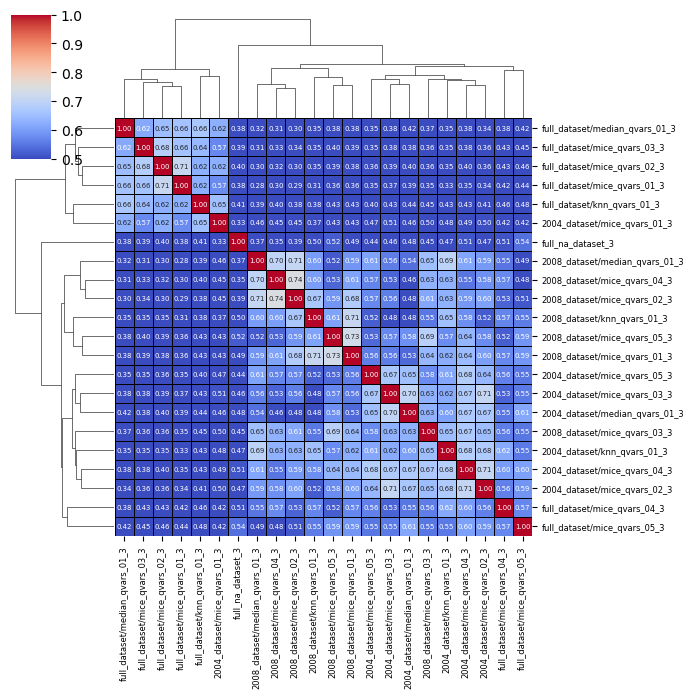

In [7]:
plot.plot_clustermap(utils.compute_ari(clusters_3_df), vmin=0.5, annot=True, fmt=".2f", annot_kws={"size": 5})
plt.savefig("figures/adjusted_rand_index_3_heatmap.pdf", dpi=300, bbox_inches="tight")

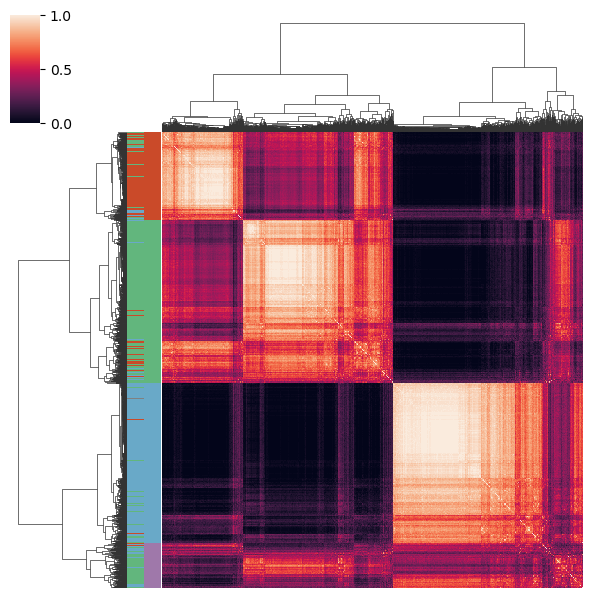

In [8]:
m1 = clusters_3_df['full_na_dataset_3'].fillna("n/a").apply(lambda x: {1:"#69a9c8",2:"#62b67d", 3:"#ca4a29", "n/a":"grey"}[x])
m2 = clusters_4_df['full_dataset/mice_qvars_02_4'].fillna("n/a").apply(lambda x: {1:"#9F78AA",2:"#62b67d", 3:"#69a9c8", 4:"#ca4a29", "n/a":"grey"}[x])

plot.plot_cmatrix(result, run_name="full_dataset/mice_qvars_02", metas=[m1, m2])
plt.savefig("figures/consensus_heatmap_v2.svg", dpi=300, bbox_inches='tight')

/Users/shankaraanand/anaconda3/envs/r4/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shankaraanand/anaconda3/envs/r4/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


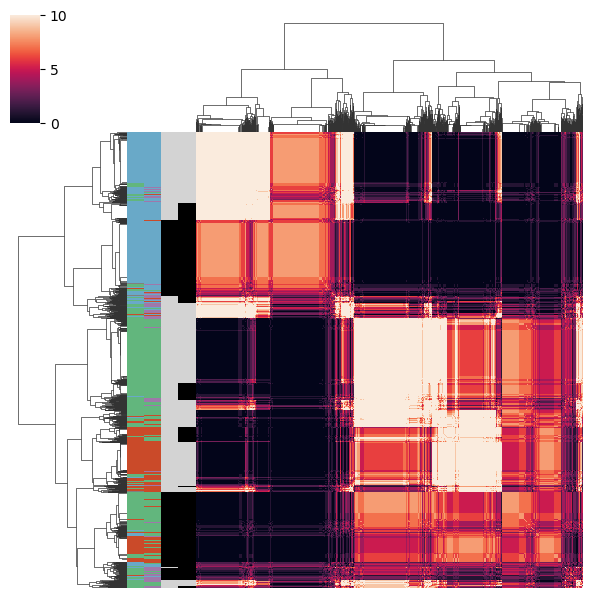

In [9]:
x = np.vstack([clusters_3_df.iloc[:,x].values for x in range(clusters_3_df.shape[1])])
consensus_matrix = np.vstack([(x[:,[y]] == x[:]).sum(0) for y in range(x.shape[1])])

# Get columns for number of datasets in
s2004 = clusters_3_df['2004_dataset/mice_qvars_04_3'].fillna(0).apply(lambda x: "black" if x==0 else "lightgrey")
s2008 = clusters_3_df['2008_dataset/mice_qvars_04_3'].fillna(0).apply(lambda x: "black" if x==0 else "lightgrey")

plot.plot_clustermap(
    consensus_matrix, 
    linewidths=0, 
    xticklabels=False, 
    yticklabels=False, 
    vmin=0, 
    vmax=10, 
    row_colors=[m1, m2, s2004, s2008], 
    cmap=None,
    figsize=(6,6),
    rasterized=True
    )

plt.savefig("figures/meta_consensus_heatmap_v2.svg", dpi=300, bbox_inches='tight')

In [138]:
meta_df = clusters_3_df[['full_na_dataset_3']].join(clusters_4_df['full_dataset/mice_qvars_02_4'])
meta_df = meta_df.rename(columns={'full_na_dataset_3':'fna3_cluster','full_dataset/mice_qvars_02_4':'m02q4_cluster'})

# Create metadata
meta_df["fna3_cluster_n"] = meta_df["fna3_cluster"].fillna('n/a').apply(lambda x: {1:'Intermediate', 2:'Low', 3:'High','n/a':None}[x])
meta_df["m02q4_cluster_n"] = meta_df["m02q4_cluster"].fillna('n/a').apply(lambda x: {4:'High', 3:'Intermediate', 2:'Low', 1:'Intermediate-Low','n/a':None}[x])
meta_df["m02q3_cluster_n"] = meta_df["m02q4_cluster_n"].fillna('n/a').apply(lambda x: {
    'High':'High','Intermediate':'Intermediate', 'Intermediate-Low':'Intermediate', 'Low':'Low'}[x])

In [142]:
data_df = data_df.drop(columns=meta_df.columns).join(meta_df)
data_df.rename(columns=amyloid.ddict_clean).to_csv(os.path.join(PROCESSED_DIR,"AL_with_ccp_03.tsv"), sep="\t")

### 3. Run Enrichments
---

In [143]:
utils.run_statistical_comparisons(data_df, "fna3_cluster_n", "data/clustering/full_na_dataset")
utils.run_statistical_comparisons(data_df, "m02q3_cluster_n", "data/clustering/full_dataset/mice_qvars_02/", tag="_3")
utils.run_statistical_comparisons(data_df, "m02q4_cluster_n", "data/clustering/full_dataset/mice_qvars_02/", tag="_4")

100%|██████████| 4/4 [00:00<00:00, 105.56it/s]


### 4. Pincipal Components Analysis
---

Can perform this either:
* With imputed data
* With probabalistic PCA (`ppca`), in exploration

In [4]:
data_df = pd.read_csv(os.path.join(PROCESSED_DIR,"AL_with_ccp_03.tsv"), sep="\t", index_col=0)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

alpha=0.5
xlim=(None, 10)
ylim=(-7.5, 7.5)

# Color Schemes
CLUSTER_COLORS = {
    "Low":"#62b67d",
    "Intermediate":"#69a9c8",
    "Intermediate-Low":"#9F78AA",
    "High":"#ca4a29"
}

BU_COLORS = {"stage I":"green","stage II":"orange","stage III":"red","stage IIIb":"purple",
             "Stage I":"green","Stage II":"orange","Stage III":"red"}

In [6]:
# Load imputed data for PCA
Xi_mice = pd.read_csv("data/imputed/full_dataset/mice_qvars_02.tsv", sep="\t").rename(
    columns={'X24_hr_UTP':'24_hr_UTP'}).rename(columns=amyloid.ddict_unclean)

# Using MICE imputed
P_df, pca, pca_vars = utils.get_pcs(Xi_mice)

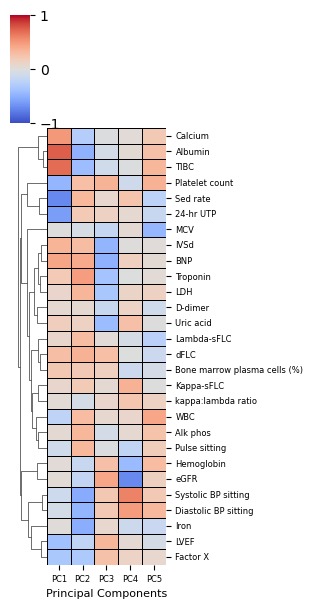

In [14]:
# Correlation between variables and PCs
plot.plot_clustermap(
    P_df.join(Xi_mice).corr('spearman').loc[Xi_mice.columns, P_df.columns].rename(columns={0:"PC1",1:"PC2",2:"PC3",3:"PC4",4:"PC5"}),
    figsize=(4,6),
    xlabel='Principal Components',
    col_cluster=False, row_cluster=True
)

plt.savefig("figures/mice_imputed_pca_corr.pdf", dpi=200, bbox_inches="tight")

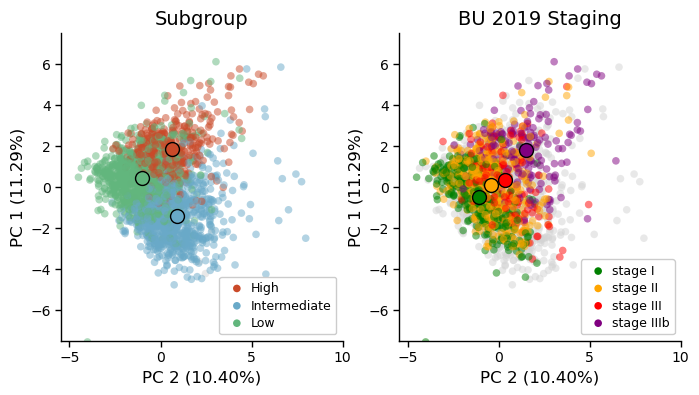

In [159]:
fig,axes = plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "fna3_cluster_n"], 
                 ax=axes[0], 
                 cohort_colors=CLUSTER_COLORS,
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"], 
                 ax=axes[1], 
                 cohort_colors=BU_COLORS,
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True,
                 )

axes[0].set_title("Subgroup", fontsize=14)
axes[1].set_title("BU 2019 Staging", fontsize=14)
plt.savefig("figures/mice_pca_clusters_vs_staging.pdf", dpi=200, bbox_inches="tight")

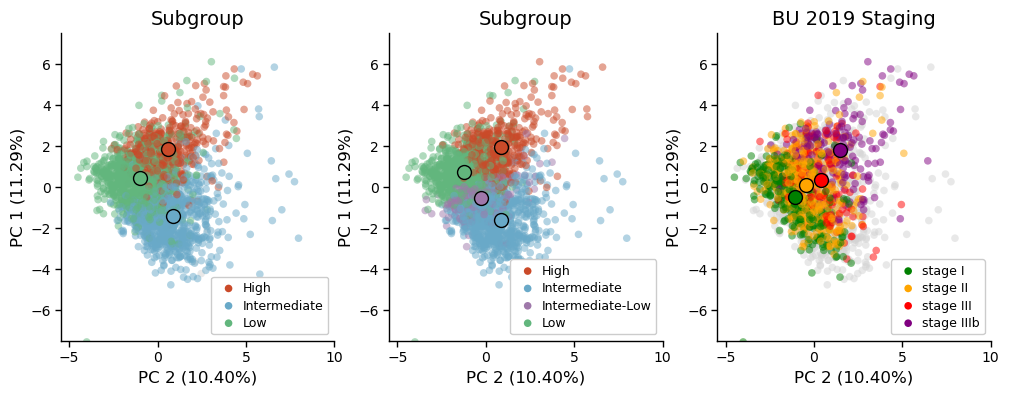

In [160]:
fig,axes = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True)

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "fna3_cluster_n"], 
                 ax=axes[0], 
                 cohort_colors=CLUSTER_COLORS,
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "m02q4_cluster_n"],
                 ax=axes[1], 
                 cohort_colors=CLUSTER_COLORS,
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"], 
                 ax=axes[2], 
                 cohort_colors=BU_COLORS,
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True,
                 )

axes[0].set_title("Subgroup", fontsize=14)
axes[1].set_title("Subgroup", fontsize=14)
axes[2].set_title("BU 2019 Staging", fontsize=14)
plt.savefig("figures/mice_pca_clusters_vs_staging_v2.pdf", dpi=200, bbox_inches="tight")

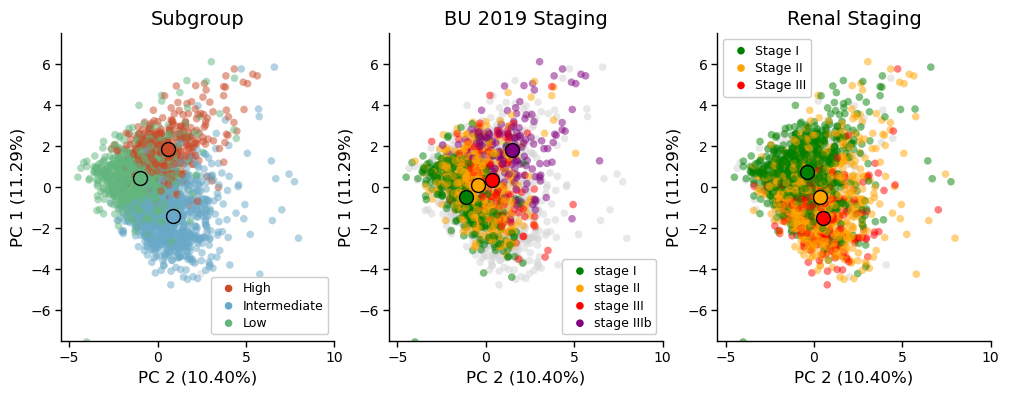

In [165]:
fig,axes = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True)

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "fna3_cluster_n"], 
                 ax=axes[0], 
                 cohort_colors=CLUSTER_COLORS,
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"], 
                 ax=axes[1], 
                 cohort_colors=BU_COLORS,
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True,
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "Renal Stage (Palladini)"], 
                 ax=axes[2], 
                 cohort_colors=BU_COLORS,
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True,
                 )

axes[0].set_title("Subgroup", fontsize=14)
axes[1].set_title("BU 2019 Staging", fontsize=14)
axes[2].set_title("Renal Staging", fontsize=14)
plt.savefig("figures/mice_pca_clusters_vs_staging_v3.pdf", dpi=200, bbox_inches="tight")

/var/folders/lq/c7twf2gd5t794j7zwhgnm8p00000gn/T/ipykernel_82330/574362844.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


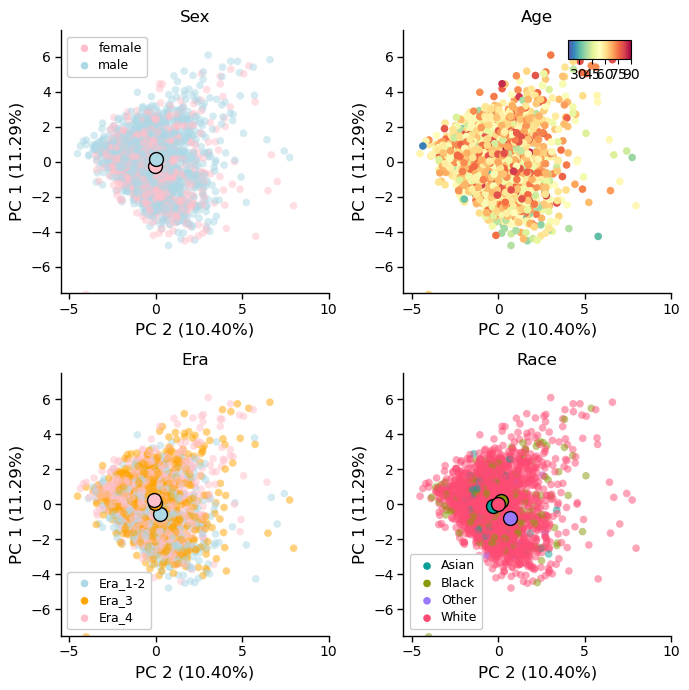

In [172]:
fig,axes = plt.subplots(2,2,figsize=(7,7), sharex=True, sharey=True)

plot.plot_pca_ax(P_df, pca, c=data_df.loc[P_df.index, "Age"], ax=axes[0,1], xlim=xlim, ylim=ylim)
plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "Sex"], ax=axes[0,0], 
                 xlim=xlim, ylim=ylim, cohort_colors={"female":"pink","male":"lightblue"}, alpha=alpha, add_mean_marker=True)
plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "Era"], ax=axes[1,0], 
                 xlim=xlim, ylim=ylim, cohort_colors={"Era_1-2":"lightblue","Era_3":"orange","Era_4":"pink"}, alpha=alpha, add_mean_marker=True)
plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "Race"].apply(
                lambda x: "Other" if x in ['American_Indian_Alaska_Native','Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'] else x),
                 ax=axes[1,1], xlim=xlim, ylim=ylim, alpha=alpha, add_mean_marker=True)

axes[0,0].set_title("Sex")
axes[0,1].set_title("Age")
axes[1,0].set_title("Era")
axes[1,1].set_title("Race")

plt.tight_layout()
plt.savefig("figures/mice_pca_demo.pdf", dpi=200, bbox_inches="tight")


/Users/shankaraanand/anaconda3/envs/r4/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


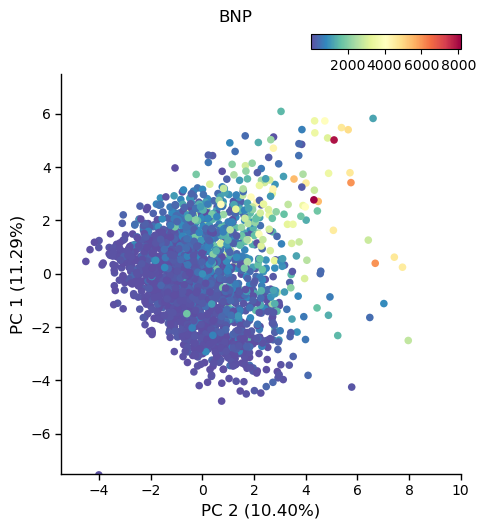

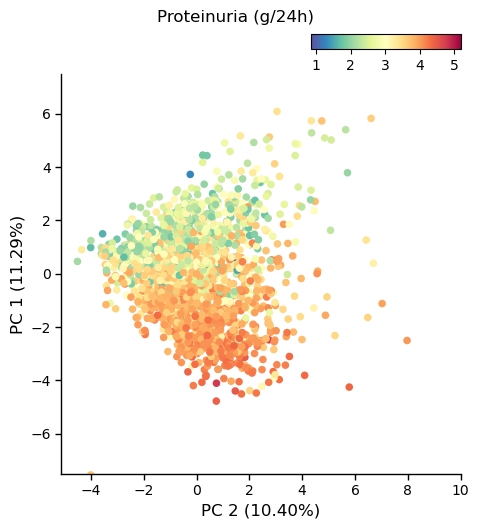

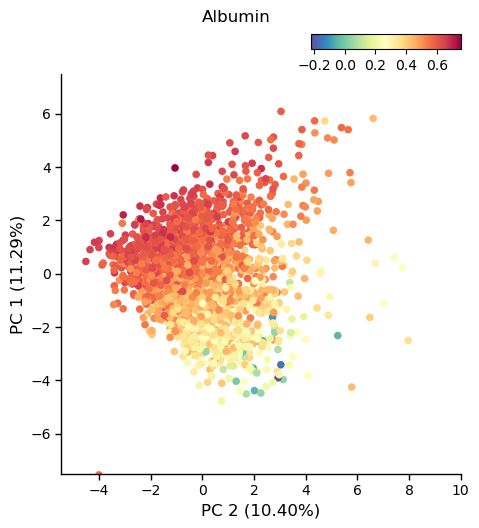

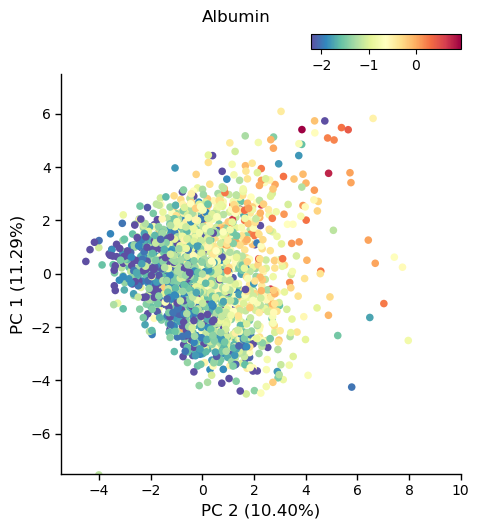

In [7]:
_ = plot.plot_pca(
    P_df,
    pca,
    c=Xi_mice.loc[P_df.index, "BNP"],
    show_ax2=False,
    xlim=xlim,
    ylim=ylim, title="BNP"
)

_ = plot.plot_pca(
    P_df,
    pca,
    c=np.log10(Xi_mice.loc[P_df.index, "24-hr UTP"]),
    show_ax2=False,
    xlim=xlim,
    ylim=ylim, title = "Proteinuria (g/24h)"
)

_ = plot.plot_pca(
    P_df,
    pca,
    c=np.log10(Xi_mice.loc[P_df.index, "Albumin"]),
    show_ax2=False,
    xlim=xlim,
    ylim=ylim, title = "Albumin"
)

_ = plot.plot_pca(
    P_df,
    pca,
    c=np.log10(Xi_mice.loc[P_df.index, "Troponin"]),
    show_ax2=False,
    xlim=xlim,
    ylim=ylim, title = "Albumin"
)

In [11]:
np.log10(np.abs(Xi_mice.loc[P_df.index, "dFLC"]+1))

6102       0.892095
9338       2.904174
9419       2.977769
9421       1.594393
9422       1.429752
             ...   
2023166    0.643453
2023177    1.750508
2023181    1.672098
2023191    1.008600
2023193    2.477989
Name: dFLC, Length: 2074, dtype: float64

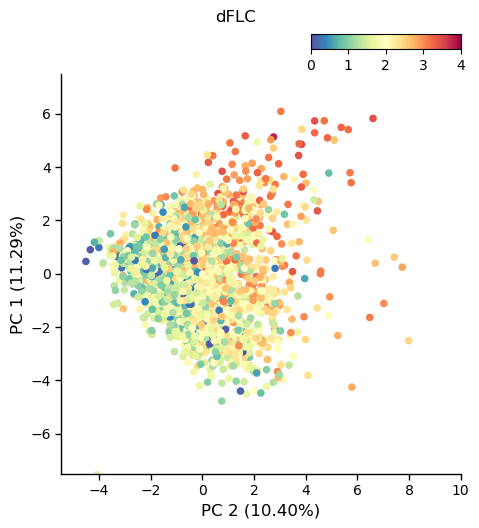

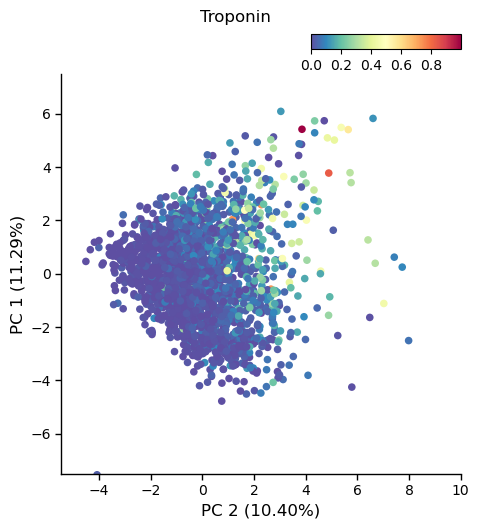

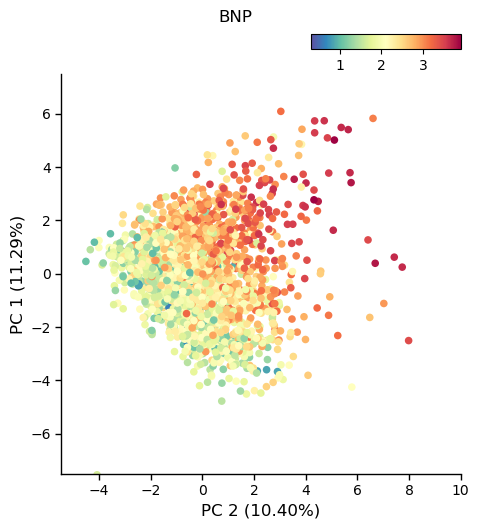

In [22]:
_ = plot.plot_pca(
    P_df,
    pca,
    c=np.log10(np.abs(Xi_mice.loc[P_df.index, "dFLC"])+1),
    show_ax2=False,
    xlim=xlim,
    ylim=ylim, title = "dFLC"
)

plt.savefig("figures/dflc_pca.svg", dpi=200)

_ = plot.plot_pca(
    P_df,
    pca,
    c=np.log10(Xi_mice.loc[P_df.index, "Troponin"]+1),
    show_ax2=False,
    xlim=xlim,
    ylim=ylim, title = "Troponin"
)
plt.savefig("figures/trop_pca.svg", dpi=200)


_ = plot.plot_pca(
    P_df,
    pca,
    c=np.log10(Xi_mice.loc[P_df.index, "BNP"]),
    show_ax2=False,
    xlim=xlim,
    ylim=ylim, title = "BNP"
)
plt.savefig("figures/bnp_pca.svg", dpi=200)


/Users/shankaraanand/anaconda3/envs/r4/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


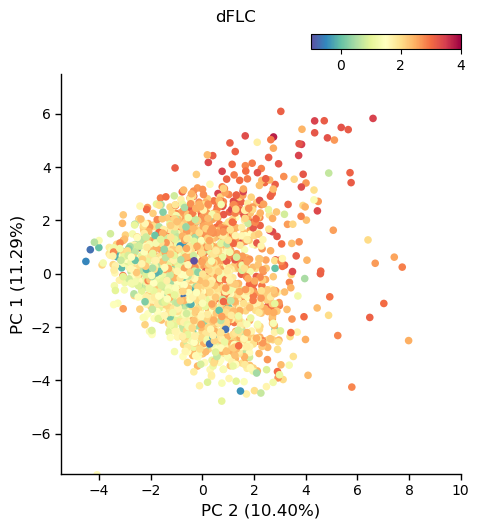

In [9]:
_ = plot.plot_pca(
    P_df,
    pca,
    c=np.log10(np.abs(Xi_mice.loc[P_df.index, "dFLC"])),
    show_ax2=False,
    xlim=xlim,
    ylim=ylim, title = "dFLC"
)

TypeError: '<' not supported between instances of 'str' and 'float'

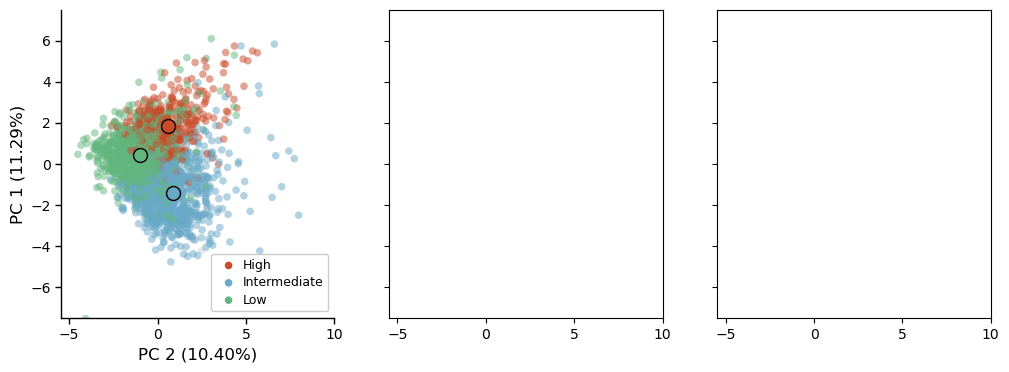

In [7]:
fig,axes = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True)

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "fna3_cluster_n"], 
                 ax=axes[0], 
                 cohort_colors=CLUSTER_COLORS,
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "dFLC"],
                 ax=axes[1], 
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"], 
                 ax=axes[2], 
                 cohort_colors=BU_COLORS,
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True,
                 )

axes[0].set_title("Subgroup", fontsize=14)
axes[1].set_title("Subgroup", fontsize=14)
axes[2].set_title("BU 2019 Staging", fontsize=14)